In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import importlib

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data/'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/'
GROUND_PATH = DATA_PATH + '/groundTruth/'
ORI_IMAGE_PATH = DATA_PATH + '/images/'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/result/'
LOG_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/logs/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test_ori.npy')
X_val = np.load(DATA_PATH + 'X_val_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_concat.npy')
y_test = np.load(DATA_PATH + 'y_test_concat.npy')
y_val = np.load(DATA_PATH + 'y_val_concat.npy')
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((200, 320, 480, 3),
 (200, 320, 480, 3),
 (100, 320, 480, 3),
 (200, 320, 480, 1),
 (200, 320, 480, 1),
 (100, 320, 480, 1))

In [4]:
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, add, Activation, Input, \
                            Lambda, MaxPooling2D, concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.initializers import he_normal, glorot_normal
from keras import backend as K
import tensorflow as tf

from loss_functions.Loss_Functions import cross_entropy_balanced, pixel_error
from my_models.U_Net import u_net_fuse

In [5]:
model_unet_fuse = u_net_fuse(input_shape=(320, 480, 3))
model_unet_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 320, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_1a (Conv2D)                (None, 320, 480, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv_1b (Conv2D)                (None, 320, 480, 16) 2320        conv_1a[0][0]                    
__________________________________________________________________________________________________
pool_1 (Ma

In [8]:
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': pixel_error},
                  optimizer=optimizer)

results = model_unet_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=300, callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/300


Epoch 00001: val_loss improved from inf to 0.94210, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5
 - 10s - loss: 0.2205 - o1_loss: 0.0310 - o2_loss: 0.0251 - o3_loss: 0.0627 - o4_loss: 0.0398 - o5_loss: 0.0391 - ofuse_loss: 0.0228 - ofuse_pixel_error: 0.1653 - val_loss: 0.9421 - val_o1_loss: 0.1634 - val_o2_loss: 0.3066 - val_o3_loss: 0.0677 - val_o4_loss: 0.0510 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.3022 - val_ofuse_pixel_error: 0.1362


Epoch 2/300


Epoch 00002: val_loss did not improve
 - 10s - loss: 0.2103 - o1_loss: 0.0294 - o2_loss: 0.0212 - o3_loss: 0.0625 - o4_loss: 0.0394 - o5_loss: 0.0385 - ofuse_loss: 0.0192 - ofuse_pixel_error: 0.1491 - val_loss: 1.0026 - val_o1_loss: 0.1649 - val_o2_loss: 0.3347 - val_o3_loss: 0.0677 - val_o4_loss: 0.0519 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3308 - val_ofuse_pixel_error: 0.1196


Epoch 3/300


Epoch 00003: val_loss did not improve
 - 10s - loss: 0.2077 - o1_loss: 0.0290 - o2_loss: 0.0201 - o3_loss: 0.0625 - o4_loss: 0.0393 - o5_loss: 0.0384 - ofuse_loss: 0.0183 - ofuse_pixel_error: 0.1432 - val_loss: 1.0158 - val_o1_loss: 0.1648 - val_o2_loss: 0.3441 - val_o3_loss: 0.0677 - val_o4_loss: 0.0511 - val_o5_loss: 0.0509 - val_ofuse_loss: 0.3373 - val_ofuse_pixel_error: 0.1260


Epoch 4/300


Epoch 00004: val_loss did not improve
 - 10s - loss: 0.2061 - o1_loss: 0.0287 - o2_loss: 0.0196 - o3_loss: 0.0626 - o4_loss: 0.0392 - o5_loss: 0.0383 - ofuse_loss: 0.0177 - ofuse_pixel_error: 0.1419 - val_loss: 1.0314 - val_o1_loss: 0.1663 - val_o2_loss: 0.3481 - val_o3_loss: 0.0677 - val_o4_loss: 0.0523 - val_o5_loss: 0.0540 - val_ofuse_loss: 0.3430 - val_ofuse_pixel_error: 0.1156


Epoch 5/300


Epoch 00005: val_loss did not improve
 - 10s - loss: 0.2067 - o1_loss: 0.0288 - o2_loss: 0.0195 - o3_loss: 0.0625 - o4_loss: 0.0395 - o5_loss: 0.0386 - ofuse_loss: 0.0178 - ofuse_pixel_error: 0.1402 - val_loss: 1.0181 - val_o1_loss: 0.1624 - val_o2_loss: 0.3464 - val_o3_loss: 0.0677 - val_o4_loss: 0.0511 - val_o5_loss: 0.0508 - val_ofuse_loss: 0.3397 - val_ofuse_pixel_error: 0.1234


Epoch 6/300


Epoch 00006: val_loss did not improve
 - 10s - loss: 0.2059 - o1_loss: 0.0285 - o2_loss: 0.0192 - o3_loss: 0.0626 - o4_loss: 0.0395 - o5_loss: 0.0386 - ofuse_loss: 0.0175 - ofuse_pixel_error: 0.1401 - val_loss: 1.0142 - val_o1_loss: 0.1625 - val_o2_loss: 0.3431 - val_o3_loss: 0.0677 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3374 - val_ofuse_pixel_error: 0.1221


Epoch 7/300


Epoch 00007: val_loss did not improve
 - 10s - loss: 0.2066 - o1_loss: 0.0287 - o2_loss: 0.0194 - o3_loss: 0.0626 - o4_loss: 0.0396 - o5_loss: 0.0387 - ofuse_loss: 0.0177 - ofuse_pixel_error: 0.1407 - val_loss: 1.0067 - val_o1_loss: 0.1613 - val_o2_loss: 0.3419 - val_o3_loss: 0.0677 - val_o4_loss: 0.0508 - val_o5_loss: 0.0503 - val_ofuse_loss: 0.3348 - val_ofuse_pixel_error: 0.1243


Epoch 8/300


Epoch 00008: val_loss did not improve
 - 10s - loss: 0.2065 - o1_loss: 0.0287 - o2_loss: 0.0195 - o3_loss: 0.0626 - o4_loss: 0.0395 - o5_loss: 0.0385 - ofuse_loss: 0.0177 - ofuse_pixel_error: 0.1421 - val_loss: 1.0067 - val_o1_loss: 0.1630 - val_o2_loss: 0.3393 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3337 - val_ofuse_pixel_error: 0.1210


Epoch 9/300


Epoch 00009: val_loss did not improve
 - 10s - loss: 0.2062 - o1_loss: 0.0287 - o2_loss: 0.0195 - o3_loss: 0.0626 - o4_loss: 0.0393 - o5_loss: 0.0383 - ofuse_loss: 0.0178 - ofuse_pixel_error: 0.1432 - val_loss: 1.0118 - val_o1_loss: 0.1607 - val_o2_loss: 0.3447 - val_o3_loss: 0.0676 - val_o4_loss: 0.0509 - val_o5_loss: 0.0506 - val_ofuse_loss: 0.3372 - val_ofuse_pixel_error: 0.1171


Epoch 10/300


Epoch 00010: val_loss did not improve
 - 10s - loss: 0.2057 - o1_loss: 0.0285 - o2_loss: 0.0192 - o3_loss: 0.0626 - o4_loss: 0.0394 - o5_loss: 0.0384 - ofuse_loss: 0.0175 - ofuse_pixel_error: 0.1406 - val_loss: 0.9752 - val_o1_loss: 0.1554 - val_o2_loss: 0.3282 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0514 - val_ofuse_loss: 0.3211 - val_ofuse_pixel_error: 0.1296


Epoch 11/300


Epoch 00011: val_loss did not improve
 - 10s - loss: 0.2064 - o1_loss: 0.0287 - o2_loss: 0.0193 - o3_loss: 0.0626 - o4_loss: 0.0396 - o5_loss: 0.0387 - ofuse_loss: 0.0176 - ofuse_pixel_error: 0.1423 - val_loss: 1.0070 - val_o1_loss: 0.1588 - val_o2_loss: 0.3408 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3351 - val_ofuse_pixel_error: 0.1184


Epoch 12/300


Epoch 00012: val_loss improved from 0.94210 to 0.92354, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5
 - 10s - loss: 0.2067 - o1_loss: 0.0287 - o2_loss: 0.0195 - o3_loss: 0.0626 - o4_loss: 0.0395 - o5_loss: 0.0386 - ofuse_loss: 0.0178 - ofuse_pixel_error: 0.1407 - val_loss: 0.9235 - val_o1_loss: 0.1486 - val_o2_loss: 0.3059 - val_o3_loss: 0.0676 - val_o4_loss: 0.0510 - val_o5_loss: 0.0507 - val_ofuse_loss: 0.2997 - val_ofuse_pixel_error: 0.1374


Epoch 13/300


Epoch 00013: val_loss did not improve
 - 10s - loss: 0.2071 - o1_loss: 0.0290 - o2_loss: 0.0198 - o3_loss: 0.0626 - o4_loss: 0.0394 - o5_loss: 0.0383 - ofuse_loss: 0.0180 - ofuse_pixel_error: 0.1450 - val_loss: 0.9626 - val_o1_loss: 0.1511 - val_o2_loss: 0.3246 - val_o3_loss: 0.0676 - val_o4_loss: 0.0512 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.3168 - val_ofuse_pixel_error: 0.1244


Epoch 14/300


Epoch 00014: val_loss did not improve
 - 10s - loss: 0.2081 - o1_loss: 0.0294 - o2_loss: 0.0201 - o3_loss: 0.0624 - o4_loss: 0.0395 - o5_loss: 0.0385 - ofuse_loss: 0.0182 - ofuse_pixel_error: 0.1422 - val_loss: 1.0244 - val_o1_loss: 0.1591 - val_o2_loss: 0.3506 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3438 - val_ofuse_pixel_error: 0.1071


Epoch 15/300


Epoch 00015: val_loss improved from 0.92354 to 0.88243, saving model to /media/tulan/Linux/Pycharm/Image_Edge/model/checkpoint.h5
 - 10s - loss: 0.2086 - o1_loss: 0.0294 - o2_loss: 0.0200 - o3_loss: 0.0625 - o4_loss: 0.0397 - o5_loss: 0.0387 - ofuse_loss: 0.0183 - ofuse_pixel_error: 0.1425 - val_loss: 0.8824 - val_o1_loss: 0.1439 - val_o2_loss: 0.2875 - val_o3_loss: 0.0676 - val_o4_loss: 0.0513 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.2809 - val_ofuse_pixel_error: 0.1536


Epoch 16/300



Epoch 00016: reducing learning rate to 0.0005000000237487257.
Epoch 00016: val_loss did not improve
 - 10s - loss: 0.2081 - o1_loss: 0.0291 - o2_loss: 0.0200 - o3_loss: 0.0626 - o4_loss: 0.0396 - o5_loss: 0.0386 - ofuse_loss: 0.0182 - ofuse_pixel_error: 0.1471 - val_loss: 0.9393 - val_o1_loss: 0.1521 - val_o2_loss: 0.3129 - val_o3_loss: 0.0676 - val_o4_loss: 0.0508 - val_o5_loss: 0.0506 - val_ofuse_loss: 0.3052 - val_ofuse_pixel_error: 0.1414


Epoch 17/300


Epoch 00017: val_loss did not improve
 - 10s - loss: 0.2058 - o1_loss: 0.0290 - o2_loss: 0.0193 - o3_loss: 0.0624 - o4_loss: 0.0392 - o5_loss: 0.0382 - ofuse_loss: 0.0176 - ofuse_pixel_error: 0.1399 - val_loss: 0.9799 - val_o1_loss: 0.1511 - val_o2_loss: 0.3328 - val_o3_loss: 0.0676 - val_o4_loss: 0.0513 - val_o5_loss: 0.0515 - val_ofuse_loss: 0.3256 - val_ofuse_pixel_error: 0.1189


Epoch 18/300


Epoch 00018: val_loss did not improve
 - 10s - loss: 0.2042 - o1_loss: 0.0285 - o2_loss: 0.0187 - o3_loss: 0.0625 - o4_loss: 0.0393 - o5_loss: 0.0382 - ofuse_loss: 0.0171 - ofuse_pixel_error: 0.1378 - val_loss: 1.0024 - val_o1_loss: 0.1547 - val_o2_loss: 0.3422 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0513 - val_ofuse_loss: 0.3351 - val_ofuse_pixel_error: 0.1216


Epoch 19/300


Epoch 00019: val_loss did not improve
 - 10s - loss: 0.2026 - o1_loss: 0.0279 - o2_loss: 0.0180 - o3_loss: 0.0626 - o4_loss: 0.0394 - o5_loss: 0.0383 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1361 - val_loss: 0.9992 - val_o1_loss: 0.1544 - val_o2_loss: 0.3409 - val_o3_loss: 0.0676 - val_o4_loss: 0.0513 - val_o5_loss: 0.0513 - val_ofuse_loss: 0.3337 - val_ofuse_pixel_error: 0.1243


Epoch 20/300


Epoch 00020: val_loss did not improve
 - 10s - loss: 0.2030 - o1_loss: 0.0281 - o2_loss: 0.0182 - o3_loss: 0.0625 - o4_loss: 0.0393 - o5_loss: 0.0382 - ofuse_loss: 0.0166 - ofuse_pixel_error: 0.1360 - val_loss: 1.0406 - val_o1_loss: 0.1582 - val_o2_loss: 0.3586 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3521 - val_ofuse_pixel_error: 0.1121


Epoch 21/300


Epoch 00021: val_loss did not improve
 - 10s - loss: 0.2036 - o1_loss: 0.0284 - o2_loss: 0.0183 - o3_loss: 0.0625 - o4_loss: 0.0394 - o5_loss: 0.0383 - ofuse_loss: 0.0168 - ofuse_pixel_error: 0.1338 - val_loss: 1.0567 - val_o1_loss: 0.1608 - val_o2_loss: 0.3664 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0514 - val_ofuse_loss: 0.3591 - val_ofuse_pixel_error: 0.1122


Epoch 22/300


Epoch 00022: val_loss did not improve
 - 10s - loss: 0.2023 - o1_loss: 0.0280 - o2_loss: 0.0180 - o3_loss: 0.0625 - o4_loss: 0.0393 - o5_loss: 0.0381 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1346 - val_loss: 1.0585 - val_o1_loss: 0.1643 - val_o2_loss: 0.3652 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3583 - val_ofuse_pixel_error: 0.1112


Epoch 23/300


Epoch 00023: val_loss did not improve
 - 10s - loss: 0.2023 - o1_loss: 0.0280 - o2_loss: 0.0180 - o3_loss: 0.0625 - o4_loss: 0.0392 - o5_loss: 0.0381 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1332 - val_loss: 1.0395 - val_o1_loss: 0.1632 - val_o2_loss: 0.3559 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3498 - val_ofuse_pixel_error: 0.1129


Epoch 24/300


Epoch 00024: val_loss did not improve
 - 10s - loss: 0.2018 - o1_loss: 0.0280 - o2_loss: 0.0180 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0379 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1339 - val_loss: 1.0127 - val_o1_loss: 0.1596 - val_o2_loss: 0.3446 - val_o3_loss: 0.0676 - val_o4_loss: 0.0513 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.3384 - val_ofuse_pixel_error: 0.1247


Epoch 25/300


Epoch 00025: val_loss did not improve
 - 10s - loss: 0.2029 - o1_loss: 0.0283 - o2_loss: 0.0182 - o3_loss: 0.0624 - o4_loss: 0.0392 - o5_loss: 0.0381 - ofuse_loss: 0.0166 - ofuse_pixel_error: 0.1327 - val_loss: 1.0371 - val_o1_loss: 0.1634 - val_o2_loss: 0.3546 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0515 - val_ofuse_loss: 0.3485 - val_ofuse_pixel_error: 0.1122


Epoch 26/300


Epoch 00026: val_loss did not improve
 - 10s - loss: 0.2016 - o1_loss: 0.0278 - o2_loss: 0.0179 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0379 - ofuse_loss: 0.0164 - ofuse_pixel_error: 0.1350 - val_loss: 1.0492 - val_o1_loss: 0.1621 - val_o2_loss: 0.3623 - val_o3_loss: 0.0676 - val_o4_loss: 0.0512 - val_o5_loss: 0.0512 - val_ofuse_loss: 0.3547 - val_ofuse_pixel_error: 0.1196


Epoch 27/300


Epoch 00027: val_loss did not improve
 - 10s - loss: 0.2022 - o1_loss: 0.0281 - o2_loss: 0.0180 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0380 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1333 - val_loss: 1.0505 - val_o1_loss: 0.1637 - val_o2_loss: 0.3619 - val_o3_loss: 0.0676 - val_o4_loss: 0.0512 - val_o5_loss: 0.0510 - val_ofuse_loss: 0.3551 - val_ofuse_pixel_error: 0.1172


Epoch 28/300


Epoch 00028: val_loss did not improve
 - 10s - loss: 0.2011 - o1_loss: 0.0277 - o2_loss: 0.0177 - o3_loss: 0.0626 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1327 - val_loss: 1.0733 - val_o1_loss: 0.1661 - val_o2_loss: 0.3708 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3650 - val_ofuse_pixel_error: 0.1095


Epoch 29/300


Epoch 00029: val_loss did not improve
 - 10s - loss: 0.2017 - o1_loss: 0.0281 - o2_loss: 0.0180 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0378 - ofuse_loss: 0.0165 - ofuse_pixel_error: 0.1326 - val_loss: 1.0444 - val_o1_loss: 0.1604 - val_o2_loss: 0.3598 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0517 - val_ofuse_loss: 0.3535 - val_ofuse_pixel_error: 0.1152


Epoch 30/300


Epoch 00030: val_loss did not improve
 - 10s - loss: 0.2010 - o1_loss: 0.0277 - o2_loss: 0.0177 - o3_loss: 0.0626 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1335 - val_loss: 1.0932 - val_o1_loss: 0.1706 - val_o2_loss: 0.3799 - val_o3_loss: 0.0676 - val_o4_loss: 0.0512 - val_o5_loss: 0.0511 - val_ofuse_loss: 0.3728 - val_ofuse_pixel_error: 0.1061


Epoch 31/300


Epoch 00031: val_loss did not improve
 - 10s - loss: 0.2009 - o1_loss: 0.0277 - o2_loss: 0.0176 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0379 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1332 - val_loss: 1.0924 - val_o1_loss: 0.1697 - val_o2_loss: 0.3787 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3727 - val_ofuse_pixel_error: 0.1069


Epoch 32/300


Epoch 00032: val_loss did not improve
 - 10s - loss: 0.2014 - o1_loss: 0.0278 - o2_loss: 0.0177 - o3_loss: 0.0626 - o4_loss: 0.0392 - o5_loss: 0.0380 - ofuse_loss: 0.0162 - ofuse_pixel_error: 0.1323 - val_loss: 1.0744 - val_o1_loss: 0.1665 - val_o2_loss: 0.3716 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3648 - val_ofuse_pixel_error: 0.1111


Epoch 33/300


Epoch 00033: val_loss did not improve
 - 10s - loss: 0.2013 - o1_loss: 0.0277 - o2_loss: 0.0176 - o3_loss: 0.0626 - o4_loss: 0.0392 - o5_loss: 0.0382 - ofuse_loss: 0.0161 - ofuse_pixel_error: 0.1320 - val_loss: 1.0917 - val_o1_loss: 0.1712 - val_o2_loss: 0.3771 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3718 - val_ofuse_pixel_error: 0.1047


Epoch 34/300


Epoch 00034: val_loss did not improve
 - 10s - loss: 0.2034 - o1_loss: 0.0283 - o2_loss: 0.0181 - o3_loss: 0.0625 - o4_loss: 0.0394 - o5_loss: 0.0384 - ofuse_loss: 0.0166 - ofuse_pixel_error: 0.1319 - val_loss: 1.0780 - val_o1_loss: 0.1673 - val_o2_loss: 0.3727 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3673 - val_ofuse_pixel_error: 0.1056


Epoch 35/300


Epoch 00035: val_loss did not improve
 - 10s - loss: 0.2015 - o1_loss: 0.0278 - o2_loss: 0.0177 - o3_loss: 0.0626 - o4_loss: 0.0392 - o5_loss: 0.0380 - ofuse_loss: 0.0162 - ofuse_pixel_error: 0.1329 - val_loss: 1.0749 - val_o1_loss: 0.1698 - val_o2_loss: 0.3700 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3640 - val_ofuse_pixel_error: 0.1083


Epoch 36/300


Epoch 00036: val_loss did not improve
 - 10s - loss: 0.2033 - o1_loss: 0.0283 - o2_loss: 0.0182 - o3_loss: 0.0624 - o4_loss: 0.0393 - o5_loss: 0.0383 - ofuse_loss: 0.0168 - ofuse_pixel_error: 0.1325 - val_loss: 1.0699 - val_o1_loss: 0.1721 - val_o2_loss: 0.3673 - val_o3_loss: 0.0676 - val_o4_loss: 0.0511 - val_o5_loss: 0.0508 - val_ofuse_loss: 0.3610 - val_ofuse_pixel_error: 0.1102


Epoch 37/300



Epoch 00037: reducing learning rate to 0.0002500000118743628.
Epoch 00037: val_loss did not improve
 - 10s - loss: 0.2032 - o1_loss: 0.0285 - o2_loss: 0.0184 - o3_loss: 0.0624 - o4_loss: 0.0391 - o5_loss: 0.0380 - ofuse_loss: 0.0168 - ofuse_pixel_error: 0.1334 - val_loss: 1.0379 - val_o1_loss: 0.1604 - val_o2_loss: 0.3573 - val_o3_loss: 0.0676 - val_o4_loss: 0.0512 - val_o5_loss: 0.0510 - val_ofuse_loss: 0.3505 - val_ofuse_pixel_error: 0.1170


Epoch 38/300


Epoch 00038: val_loss did not improve
 - 10s - loss: 0.2021 - o1_loss: 0.0278 - o2_loss: 0.0177 - o3_loss: 0.0626 - o4_loss: 0.0394 - o5_loss: 0.0383 - ofuse_loss: 0.0162 - ofuse_pixel_error: 0.1321 - val_loss: 1.0669 - val_o1_loss: 0.1663 - val_o2_loss: 0.3681 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0515 - val_ofuse_loss: 0.3619 - val_ofuse_pixel_error: 0.1128


Epoch 39/300


Epoch 00039: val_loss did not improve
 - 10s - loss: 0.2009 - o1_loss: 0.0279 - o2_loss: 0.0177 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0162 - ofuse_pixel_error: 0.1318 - val_loss: 1.0766 - val_o1_loss: 0.1657 - val_o2_loss: 0.3730 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3670 - val_ofuse_pixel_error: 0.1105


Epoch 40/300


Epoch 00040: val_loss did not improve
 - 10s - loss: 0.2005 - o1_loss: 0.0276 - o2_loss: 0.0174 - o3_loss: 0.0626 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1306 - val_loss: 1.1056 - val_o1_loss: 0.1722 - val_o2_loss: 0.3841 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3780 - val_ofuse_pixel_error: 0.1028


Epoch 41/300


Epoch 00041: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1303 - val_loss: 1.1050 - val_o1_loss: 0.1712 - val_o2_loss: 0.3846 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0517 - val_ofuse_loss: 0.3784 - val_ofuse_pixel_error: 0.1060


Epoch 42/300


Epoch 00042: val_loss did not improve
 - 10s - loss: 0.2008 - o1_loss: 0.0278 - o2_loss: 0.0175 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1298 - val_loss: 1.1141 - val_o1_loss: 0.1723 - val_o2_loss: 0.3881 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3823 - val_ofuse_pixel_error: 0.1012


Epoch 43/300


Epoch 00043: val_loss did not improve
 - 10s - loss: 0.1998 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1305 - val_loss: 1.1320 - val_o1_loss: 0.1741 - val_o2_loss: 0.3961 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3901 - val_ofuse_pixel_error: 0.0983


Epoch 44/300


Epoch 00044: val_loss did not improve
 - 10s - loss: 0.2004 - o1_loss: 0.0275 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0392 - o5_loss: 0.0380 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1294 - val_loss: 1.1157 - val_o1_loss: 0.1724 - val_o2_loss: 0.3881 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3828 - val_ofuse_pixel_error: 0.1012


Epoch 45/300


Epoch 00045: val_loss did not improve
 - 10s - loss: 0.2008 - o1_loss: 0.0278 - o2_loss: 0.0175 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1297 - val_loss: 1.0992 - val_o1_loss: 0.1705 - val_o2_loss: 0.3817 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3755 - val_ofuse_pixel_error: 0.1091


Epoch 46/300


Epoch 00046: val_loss did not improve
 - 10s - loss: 0.2005 - o1_loss: 0.0278 - o2_loss: 0.0175 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1301 - val_loss: 1.1392 - val_o1_loss: 0.1761 - val_o2_loss: 0.3994 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0514 - val_ofuse_loss: 0.3932 - val_ofuse_pixel_error: 0.0968


Epoch 47/300



Epoch 00047: reducing learning rate to 0.0001250000059371814.
Epoch 00047: val_loss did not improve
 - 10s - loss: 0.2006 - o1_loss: 0.0277 - o2_loss: 0.0175 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1291 - val_loss: 1.0814 - val_o1_loss: 0.1687 - val_o2_loss: 0.3736 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3677 - val_ofuse_pixel_error: 0.1106


Epoch 48/300


Epoch 00048: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0272 - o2_loss: 0.0171 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1305 - val_loss: 1.1154 - val_o1_loss: 0.1742 - val_o2_loss: 0.3875 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3819 - val_ofuse_pixel_error: 0.1033


Epoch 49/300


Epoch 00049: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1294 - val_loss: 1.0754 - val_o1_loss: 0.1683 - val_o2_loss: 0.3711 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3654 - val_ofuse_pixel_error: 0.1148


Epoch 50/300


Epoch 00050: val_loss did not improve
 - 10s - loss: 0.2007 - o1_loss: 0.0279 - o2_loss: 0.0175 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0160 - ofuse_pixel_error: 0.1291 - val_loss: 1.1150 - val_o1_loss: 0.1734 - val_o2_loss: 0.3881 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3823 - val_ofuse_pixel_error: 0.1033


Epoch 51/300


Epoch 00051: val_loss did not improve
 - 10s - loss: 0.1995 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1291 - val_loss: 1.1047 - val_o1_loss: 0.1715 - val_o2_loss: 0.3847 - val_o3_loss: 0.0676 - val_o4_loss: 0.0513 - val_o5_loss: 0.0513 - val_ofuse_loss: 0.3783 - val_ofuse_pixel_error: 0.1093


Epoch 52/300


Epoch 00052: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1288 - val_loss: 1.1106 - val_o1_loss: 0.1730 - val_o2_loss: 0.3865 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3805 - val_ofuse_pixel_error: 0.1063


Epoch 53/300


Epoch 00053: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1291 - val_loss: 1.1209 - val_o1_loss: 0.1742 - val_o2_loss: 0.3900 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3847 - val_ofuse_pixel_error: 0.1011


Epoch 54/300



Epoch 00054: reducing learning rate to 0.0001.
Epoch 00054: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1285 - val_loss: 1.1028 - val_o1_loss: 0.1708 - val_o2_loss: 0.3837 - val_o3_loss: 0.0676 - val_o4_loss: 0.0514 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3777 - val_ofuse_pixel_error: 0.1097


Epoch 55/300


Epoch 00055: val_loss did not improve
 - 10s - loss: 0.2004 - o1_loss: 0.0278 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1286 - val_loss: 1.1096 - val_o1_loss: 0.1736 - val_o2_loss: 0.3849 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3794 - val_ofuse_pixel_error: 0.1057


Epoch 56/300


Epoch 00056: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1293 - val_loss: 1.1219 - val_o1_loss: 0.1743 - val_o2_loss: 0.3904 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3850 - val_ofuse_pixel_error: 0.1023


Epoch 57/300


Epoch 00057: val_loss did not improve
 - 10s - loss: 0.2001 - o1_loss: 0.0276 - o2_loss: 0.0174 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1295 - val_loss: 1.1290 - val_o1_loss: 0.1762 - val_o2_loss: 0.3935 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3880 - val_ofuse_pixel_error: 0.1010


Epoch 58/300


Epoch 00058: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1284 - val_loss: 1.1296 - val_o1_loss: 0.1752 - val_o2_loss: 0.3947 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3887 - val_ofuse_pixel_error: 0.1034


Epoch 59/300


Epoch 00059: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1281 - val_loss: 1.1045 - val_o1_loss: 0.1723 - val_o2_loss: 0.3832 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3777 - val_ofuse_pixel_error: 0.1083


Epoch 60/300


Epoch 00060: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1290 - val_loss: 1.1256 - val_o1_loss: 0.1759 - val_o2_loss: 0.3918 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3864 - val_ofuse_pixel_error: 0.1024


Epoch 61/300


Epoch 00061: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1282 - val_loss: 1.1166 - val_o1_loss: 0.1740 - val_o2_loss: 0.3885 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3829 - val_ofuse_pixel_error: 0.1048


Epoch 62/300


Epoch 00062: val_loss did not improve
 - 10s - loss: 0.2002 - o1_loss: 0.0277 - o2_loss: 0.0174 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1282 - val_loss: 1.1109 - val_o1_loss: 0.1740 - val_o2_loss: 0.3858 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3802 - val_ofuse_pixel_error: 0.1048


Epoch 63/300


Epoch 00063: val_loss did not improve
 - 10s - loss: 0.1997 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1287 - val_loss: 1.1212 - val_o1_loss: 0.1749 - val_o2_loss: 0.3904 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3848 - val_ofuse_pixel_error: 0.1049


Epoch 64/300


Epoch 00064: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1286 - val_loss: 1.1312 - val_o1_loss: 0.1760 - val_o2_loss: 0.3949 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3892 - val_ofuse_pixel_error: 0.1019


Epoch 65/300


Epoch 00065: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1282 - val_loss: 1.1200 - val_o1_loss: 0.1743 - val_o2_loss: 0.3899 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3845 - val_ofuse_pixel_error: 0.1041


Epoch 66/300


Epoch 00066: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1287 - val_loss: 1.1164 - val_o1_loss: 0.1737 - val_o2_loss: 0.3885 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3830 - val_ofuse_pixel_error: 0.1063


Epoch 67/300


Epoch 00067: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0272 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1286 - val_loss: 1.1217 - val_o1_loss: 0.1751 - val_o2_loss: 0.3903 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3850 - val_ofuse_pixel_error: 0.1042


Epoch 68/300


Epoch 00068: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1291 - val_loss: 1.1384 - val_o1_loss: 0.1772 - val_o2_loss: 0.3977 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3920 - val_ofuse_pixel_error: 0.1016


Epoch 69/300


Epoch 00069: val_loss did not improve
 - 10s - loss: 0.1997 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1278 - val_loss: 1.1144 - val_o1_loss: 0.1746 - val_o2_loss: 0.3871 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3816 - val_ofuse_pixel_error: 0.1068


Epoch 70/300


Epoch 00070: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1290 - val_loss: 1.1399 - val_o1_loss: 0.1771 - val_o2_loss: 0.3983 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3929 - val_ofuse_pixel_error: 0.1011


Epoch 71/300


Epoch 00071: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1284 - val_loss: 1.1258 - val_o1_loss: 0.1760 - val_o2_loss: 0.3919 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3865 - val_ofuse_pixel_error: 0.1034


Epoch 72/300


Epoch 00072: val_loss did not improve
 - 10s - loss: 0.1997 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1278 - val_loss: 1.1225 - val_o1_loss: 0.1760 - val_o2_loss: 0.3905 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3850 - val_ofuse_pixel_error: 0.1047


Epoch 73/300


Epoch 00073: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1282 - val_loss: 1.1327 - val_o1_loss: 0.1766 - val_o2_loss: 0.3952 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3897 - val_ofuse_pixel_error: 0.1022


Epoch 74/300


Epoch 00074: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1283 - val_loss: 1.1239 - val_o1_loss: 0.1753 - val_o2_loss: 0.3919 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3860 - val_ofuse_pixel_error: 0.1067


Epoch 75/300


Epoch 00075: val_loss did not improve
 - 10s - loss: 0.1997 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1284 - val_loss: 1.1397 - val_o1_loss: 0.1782 - val_o2_loss: 0.3978 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3924 - val_ofuse_pixel_error: 0.1010


Epoch 76/300


Epoch 00076: val_loss did not improve
 - 10s - loss: 0.1998 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1274 - val_loss: 1.1293 - val_o1_loss: 0.1772 - val_o2_loss: 0.3933 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3877 - val_ofuse_pixel_error: 0.1034


Epoch 77/300


Epoch 00077: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1285 - val_loss: 1.1243 - val_o1_loss: 0.1760 - val_o2_loss: 0.3907 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3856 - val_ofuse_pixel_error: 0.1053


Epoch 78/300


Epoch 00078: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1286 - val_loss: 1.1398 - val_o1_loss: 0.1782 - val_o2_loss: 0.3980 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3924 - val_ofuse_pixel_error: 0.1024


Epoch 79/300


Epoch 00079: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1276 - val_loss: 1.1379 - val_o1_loss: 0.1773 - val_o2_loss: 0.3979 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0517 - val_ofuse_loss: 0.3920 - val_ofuse_pixel_error: 0.1031


Epoch 80/300


Epoch 00080: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0272 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1284 - val_loss: 1.1378 - val_o1_loss: 0.1777 - val_o2_loss: 0.3971 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3917 - val_ofuse_pixel_error: 0.1019


Epoch 81/300


Epoch 00081: val_loss did not improve
 - 10s - loss: 0.2003 - o1_loss: 0.0278 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1276 - val_loss: 1.1369 - val_o1_loss: 0.1780 - val_o2_loss: 0.3969 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0516 - val_ofuse_loss: 0.3913 - val_ofuse_pixel_error: 0.1049


Epoch 82/300


Epoch 00082: val_loss did not improve
 - 10s - loss: 0.2001 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1278 - val_loss: 1.1318 - val_o1_loss: 0.1779 - val_o2_loss: 0.3935 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3885 - val_ofuse_pixel_error: 0.1023


Epoch 83/300


Epoch 00083: val_loss did not improve
 - 10s - loss: 0.1998 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1274 - val_loss: 1.1331 - val_o1_loss: 0.1771 - val_o2_loss: 0.3946 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3896 - val_ofuse_pixel_error: 0.1031


Epoch 84/300


Epoch 00084: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0378 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1279 - val_loss: 1.1160 - val_o1_loss: 0.1759 - val_o2_loss: 0.3869 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3817 - val_ofuse_pixel_error: 0.1064


Epoch 85/300


Epoch 00085: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1288 - val_loss: 1.1420 - val_o1_loss: 0.1791 - val_o2_loss: 0.3985 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3932 - val_ofuse_pixel_error: 0.1019


Epoch 86/300


Epoch 00086: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1280 - val_loss: 1.1434 - val_o1_loss: 0.1778 - val_o2_loss: 0.3994 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3943 - val_ofuse_pixel_error: 0.1023


Epoch 87/300


Epoch 00087: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1282 - val_loss: 1.1389 - val_o1_loss: 0.1782 - val_o2_loss: 0.3974 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3921 - val_ofuse_pixel_error: 0.1029


Epoch 88/300


Epoch 00088: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1276 - val_loss: 1.1346 - val_o1_loss: 0.1781 - val_o2_loss: 0.3953 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3898 - val_ofuse_pixel_error: 0.1041


Epoch 89/300


Epoch 00089: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1274 - val_loss: 1.1358 - val_o1_loss: 0.1792 - val_o2_loss: 0.3951 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3900 - val_ofuse_pixel_error: 0.1024


Epoch 90/300


Epoch 00090: val_loss did not improve
 - 10s - loss: 0.2006 - o1_loss: 0.0277 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0392 - o5_loss: 0.0380 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1281 - val_loss: 1.1435 - val_o1_loss: 0.1806 - val_o2_loss: 0.3973 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.3929 - val_ofuse_pixel_error: 0.0983


Epoch 91/300


Epoch 00091: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1284 - val_loss: 1.1325 - val_o1_loss: 0.1782 - val_o2_loss: 0.3943 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3889 - val_ofuse_pixel_error: 0.1041


Epoch 92/300


Epoch 00092: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1284 - val_loss: 1.1256 - val_o1_loss: 0.1765 - val_o2_loss: 0.3916 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3864 - val_ofuse_pixel_error: 0.1068


Epoch 93/300


Epoch 00093: val_loss did not improve
 - 10s - loss: 0.2004 - o1_loss: 0.0278 - o2_loss: 0.0174 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1274 - val_loss: 1.1238 - val_o1_loss: 0.1755 - val_o2_loss: 0.3913 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3859 - val_ofuse_pixel_error: 0.1070


Epoch 94/300


Epoch 00094: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1283 - val_loss: 1.1402 - val_o1_loss: 0.1785 - val_o2_loss: 0.3973 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3924 - val_ofuse_pixel_error: 0.1007


Epoch 95/300


Epoch 00095: val_loss did not improve
 - 10s - loss: 0.2002 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0378 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1276 - val_loss: 1.1277 - val_o1_loss: 0.1782 - val_o2_loss: 0.3919 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3866 - val_ofuse_pixel_error: 0.1043


Epoch 96/300


Epoch 00096: val_loss did not improve
 - 10s - loss: 0.2001 - o1_loss: 0.0277 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1275 - val_loss: 1.1355 - val_o1_loss: 0.1774 - val_o2_loss: 0.3957 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3906 - val_ofuse_pixel_error: 0.1030


Epoch 97/300


Epoch 00097: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1287 - val_loss: 1.1434 - val_o1_loss: 0.1797 - val_o2_loss: 0.3988 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3935 - val_ofuse_pixel_error: 0.1031


Epoch 98/300


Epoch 00098: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1272 - val_loss: 1.1359 - val_o1_loss: 0.1801 - val_o2_loss: 0.3942 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.3894 - val_ofuse_pixel_error: 0.1027


Epoch 99/300


Epoch 00099: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1276 - val_loss: 1.1171 - val_o1_loss: 0.1762 - val_o2_loss: 0.3873 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3822 - val_ofuse_pixel_error: 0.1086


Epoch 100/300


Epoch 00100: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0275 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1290 - val_loss: 1.1435 - val_o1_loss: 0.1795 - val_o2_loss: 0.3990 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3937 - val_ofuse_pixel_error: 0.1028


Epoch 101/300


Epoch 00101: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1279 - val_loss: 1.1469 - val_o1_loss: 0.1797 - val_o2_loss: 0.4006 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3954 - val_ofuse_pixel_error: 0.1016


Epoch 102/300


Epoch 00102: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1281 - val_loss: 1.1437 - val_o1_loss: 0.1787 - val_o2_loss: 0.3991 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3940 - val_ofuse_pixel_error: 0.1016


Epoch 103/300


Epoch 00103: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1276 - val_loss: 1.1422 - val_o1_loss: 0.1793 - val_o2_loss: 0.3986 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3932 - val_ofuse_pixel_error: 0.1039


Epoch 104/300


Epoch 00104: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1287 - val_loss: 1.1407 - val_o1_loss: 0.1792 - val_o2_loss: 0.3976 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3925 - val_ofuse_pixel_error: 0.1020


Epoch 105/300


Epoch 00105: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1275 - val_loss: 1.1366 - val_o1_loss: 0.1796 - val_o2_loss: 0.3950 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3900 - val_ofuse_pixel_error: 0.1030


Epoch 106/300


Epoch 00106: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1284 - val_loss: 1.1605 - val_o1_loss: 0.1818 - val_o2_loss: 0.4064 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4011 - val_ofuse_pixel_error: 0.0995


Epoch 107/300


Epoch 00107: val_loss did not improve
 - 10s - loss: 0.1998 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1271 - val_loss: 1.1293 - val_o1_loss: 0.1787 - val_o2_loss: 0.3920 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3872 - val_ofuse_pixel_error: 0.1034


Epoch 108/300


Epoch 00108: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1278 - val_loss: 1.1323 - val_o1_loss: 0.1791 - val_o2_loss: 0.3934 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3883 - val_ofuse_pixel_error: 0.1050


Epoch 109/300


Epoch 00109: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1286 - val_loss: 1.1617 - val_o1_loss: 0.1819 - val_o2_loss: 0.4065 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4014 - val_ofuse_pixel_error: 0.0987


Epoch 110/300


Epoch 00110: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1278 - val_loss: 1.1489 - val_o1_loss: 0.1812 - val_o2_loss: 0.4004 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3954 - val_ofuse_pixel_error: 0.1018


Epoch 111/300


Epoch 00111: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1280 - val_loss: 1.1392 - val_o1_loss: 0.1807 - val_o2_loss: 0.3959 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3911 - val_ofuse_pixel_error: 0.1021


Epoch 112/300


Epoch 00112: val_loss did not improve
 - 10s - loss: 0.1999 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0391 - o5_loss: 0.0379 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1279 - val_loss: 1.1526 - val_o1_loss: 0.1812 - val_o2_loss: 0.4027 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3976 - val_ofuse_pixel_error: 0.1018


Epoch 113/300


Epoch 00113: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1278 - val_loss: 1.1464 - val_o1_loss: 0.1807 - val_o2_loss: 0.3997 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3947 - val_ofuse_pixel_error: 0.1025


Epoch 114/300


Epoch 00114: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1272 - val_loss: 1.1371 - val_o1_loss: 0.1798 - val_o2_loss: 0.3955 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3904 - val_ofuse_pixel_error: 0.1043


Epoch 115/300


Epoch 00115: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1287 - val_loss: 1.1664 - val_o1_loss: 0.1837 - val_o2_loss: 0.4077 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4028 - val_ofuse_pixel_error: 0.0960


Epoch 116/300


Epoch 00116: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1277 - val_loss: 1.1608 - val_o1_loss: 0.1830 - val_o2_loss: 0.4058 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4007 - val_ofuse_pixel_error: 0.0994


Epoch 117/300


Epoch 00117: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1284 - val_loss: 1.1798 - val_o1_loss: 0.1855 - val_o2_loss: 0.4139 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4089 - val_ofuse_pixel_error: 0.0943


Epoch 118/300


Epoch 00118: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1269 - val_loss: 1.1380 - val_o1_loss: 0.1805 - val_o2_loss: 0.3950 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3902 - val_ofuse_pixel_error: 0.1032


Epoch 119/300


Epoch 00119: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1283 - val_loss: 1.1623 - val_o1_loss: 0.1827 - val_o2_loss: 0.4064 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4016 - val_ofuse_pixel_error: 0.0984


Epoch 120/300


Epoch 00120: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1271 - val_loss: 1.1469 - val_o1_loss: 0.1809 - val_o2_loss: 0.3998 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3947 - val_ofuse_pixel_error: 0.1027


Epoch 121/300


Epoch 00121: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1280 - val_loss: 1.1609 - val_o1_loss: 0.1823 - val_o2_loss: 0.4053 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4007 - val_ofuse_pixel_error: 0.0967


Epoch 122/300


Epoch 00122: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1279 - val_loss: 1.1648 - val_o1_loss: 0.1832 - val_o2_loss: 0.4073 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4024 - val_ofuse_pixel_error: 0.0986


Epoch 123/300


Epoch 00123: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1275 - val_loss: 1.1555 - val_o1_loss: 0.1820 - val_o2_loss: 0.4033 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3985 - val_ofuse_pixel_error: 0.1005


Epoch 124/300


Epoch 00124: val_loss did not improve
 - 10s - loss: 0.1995 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0624 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1270 - val_loss: 1.1508 - val_o1_loss: 0.1814 - val_o2_loss: 0.4005 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.3960 - val_ofuse_pixel_error: 0.1008


Epoch 125/300


Epoch 00125: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1651 - val_o1_loss: 0.1838 - val_o2_loss: 0.4077 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.4025 - val_ofuse_pixel_error: 0.0986


Epoch 126/300


Epoch 00126: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1273 - val_loss: 1.1607 - val_o1_loss: 0.1833 - val_o2_loss: 0.4058 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4004 - val_ofuse_pixel_error: 0.1008


Epoch 127/300


Epoch 00127: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1277 - val_loss: 1.1441 - val_o1_loss: 0.1804 - val_o2_loss: 0.3988 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3938 - val_ofuse_pixel_error: 0.1057


Epoch 128/300


Epoch 00128: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1276 - val_loss: 1.1524 - val_o1_loss: 0.1816 - val_o2_loss: 0.4021 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3970 - val_ofuse_pixel_error: 0.1023


Epoch 129/300


Epoch 00129: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1278 - val_loss: 1.1635 - val_o1_loss: 0.1835 - val_o2_loss: 0.4071 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4018 - val_ofuse_pixel_error: 0.1002


Epoch 130/300


Epoch 00130: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1455 - val_o1_loss: 0.1826 - val_o2_loss: 0.3984 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3934 - val_ofuse_pixel_error: 0.1034


Epoch 131/300


Epoch 00131: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1279 - val_loss: 1.1473 - val_o1_loss: 0.1826 - val_o2_loss: 0.3995 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3943 - val_ofuse_pixel_error: 0.1041


Epoch 132/300


Epoch 00132: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1531 - val_o1_loss: 0.1818 - val_o2_loss: 0.4019 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3971 - val_ofuse_pixel_error: 0.1017


Epoch 133/300


Epoch 00133: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1269 - val_loss: 1.1517 - val_o1_loss: 0.1818 - val_o2_loss: 0.4020 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3969 - val_ofuse_pixel_error: 0.1037


Epoch 134/300


Epoch 00134: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1278 - val_loss: 1.1729 - val_o1_loss: 0.1853 - val_o2_loss: 0.4106 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4056 - val_ofuse_pixel_error: 0.0965


Epoch 135/300


Epoch 00135: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1272 - val_loss: 1.1379 - val_o1_loss: 0.1808 - val_o2_loss: 0.3957 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0517 - val_ofuse_loss: 0.3905 - val_ofuse_pixel_error: 0.1060


Epoch 136/300


Epoch 00136: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0275 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1548 - val_o1_loss: 0.1825 - val_o2_loss: 0.4029 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3979 - val_ofuse_pixel_error: 0.1015


Epoch 137/300


Epoch 00137: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0272 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1269 - val_loss: 1.1518 - val_o1_loss: 0.1826 - val_o2_loss: 0.4014 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3963 - val_ofuse_pixel_error: 0.1029


Epoch 138/300


Epoch 00138: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1277 - val_loss: 1.1635 - val_o1_loss: 0.1852 - val_o2_loss: 0.4057 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4008 - val_ofuse_pixel_error: 0.0995


Epoch 139/300


Epoch 00139: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1269 - val_loss: 1.1539 - val_o1_loss: 0.1828 - val_o2_loss: 0.4024 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3973 - val_ofuse_pixel_error: 0.1039


Epoch 140/300


Epoch 00140: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1279 - val_loss: 1.1695 - val_o1_loss: 0.1845 - val_o2_loss: 0.4096 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.4043 - val_ofuse_pixel_error: 0.0990


Epoch 141/300


Epoch 00141: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1271 - val_loss: 1.1619 - val_o1_loss: 0.1842 - val_o2_loss: 0.4057 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4007 - val_ofuse_pixel_error: 0.1007


Epoch 142/300


Epoch 00142: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1277 - val_loss: 1.1640 - val_o1_loss: 0.1846 - val_o2_loss: 0.4059 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4013 - val_ofuse_pixel_error: 0.0984


Epoch 143/300


Epoch 00143: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1268 - val_loss: 1.1651 - val_o1_loss: 0.1842 - val_o2_loss: 0.4069 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4022 - val_ofuse_pixel_error: 0.0990


Epoch 144/300


Epoch 00144: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1278 - val_loss: 1.1605 - val_o1_loss: 0.1849 - val_o2_loss: 0.4047 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3996 - val_ofuse_pixel_error: 0.1005


Epoch 145/300


Epoch 00145: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1275 - val_loss: 1.1651 - val_o1_loss: 0.1845 - val_o2_loss: 0.4069 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4020 - val_ofuse_pixel_error: 0.0981


Epoch 146/300


Epoch 00146: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1272 - val_loss: 1.1535 - val_o1_loss: 0.1825 - val_o2_loss: 0.4023 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3974 - val_ofuse_pixel_error: 0.1034


Epoch 147/300


Epoch 00147: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0276 - o2_loss: 0.0173 - o3_loss: 0.0624 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1265 - val_loss: 1.1432 - val_o1_loss: 0.1814 - val_o2_loss: 0.3977 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3929 - val_ofuse_pixel_error: 0.1043


Epoch 148/300


Epoch 00148: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1525 - val_o1_loss: 0.1822 - val_o2_loss: 0.4022 - val_o3_loss: 0.0676 - val_o4_loss: 0.0515 - val_o5_loss: 0.0517 - val_ofuse_loss: 0.3973 - val_ofuse_pixel_error: 0.1034


Epoch 149/300


Epoch 00149: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1278 - val_loss: 1.1625 - val_o1_loss: 0.1850 - val_o2_loss: 0.4054 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4005 - val_ofuse_pixel_error: 0.1008


Epoch 150/300


Epoch 00150: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1279 - val_loss: 1.1617 - val_o1_loss: 0.1839 - val_o2_loss: 0.4057 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4007 - val_ofuse_pixel_error: 0.1016


Epoch 151/300


Epoch 00151: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1265 - val_loss: 1.1679 - val_o1_loss: 0.1854 - val_o2_loss: 0.4081 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4030 - val_ofuse_pixel_error: 0.1001


Epoch 152/300


Epoch 00152: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1272 - val_loss: 1.1605 - val_o1_loss: 0.1843 - val_o2_loss: 0.4044 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3999 - val_ofuse_pixel_error: 0.0999


Epoch 153/300


Epoch 00153: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1276 - val_loss: 1.1501 - val_o1_loss: 0.1844 - val_o2_loss: 0.3997 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3948 - val_ofuse_pixel_error: 0.1042


Epoch 154/300


Epoch 00154: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1277 - val_loss: 1.1729 - val_o1_loss: 0.1860 - val_o2_loss: 0.4097 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4050 - val_ofuse_pixel_error: 0.0979


Epoch 155/300


Epoch 00155: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1275 - val_loss: 1.1598 - val_o1_loss: 0.1836 - val_o2_loss: 0.4049 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4001 - val_ofuse_pixel_error: 0.1029


Epoch 156/300


Epoch 00156: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1269 - val_loss: 1.1608 - val_o1_loss: 0.1838 - val_o2_loss: 0.4049 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4002 - val_ofuse_pixel_error: 0.1005


Epoch 157/300


Epoch 00157: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1278 - val_loss: 1.1824 - val_o1_loss: 0.1876 - val_o2_loss: 0.4135 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4089 - val_ofuse_pixel_error: 0.0960


Epoch 158/300


Epoch 00158: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 1.1498 - val_o1_loss: 0.1839 - val_o2_loss: 0.3998 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3950 - val_ofuse_pixel_error: 0.1041


Epoch 159/300


Epoch 00159: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1271 - val_loss: 1.1572 - val_o1_loss: 0.1835 - val_o2_loss: 0.4034 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3987 - val_ofuse_pixel_error: 0.1012


Epoch 160/300


Epoch 00160: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0270 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1281 - val_loss: 1.1658 - val_o1_loss: 0.1853 - val_o2_loss: 0.4068 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4022 - val_ofuse_pixel_error: 0.1008


Epoch 161/300


Epoch 00161: val_loss did not improve
 - 10s - loss: 0.1992 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1267 - val_loss: 1.1592 - val_o1_loss: 0.1850 - val_o2_loss: 0.4042 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3990 - val_ofuse_pixel_error: 0.1026


Epoch 162/300


Epoch 00162: val_loss did not improve
 - 10s - loss: 0.1994 - o1_loss: 0.0276 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1268 - val_loss: 1.1607 - val_o1_loss: 0.1849 - val_o2_loss: 0.4039 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3995 - val_ofuse_pixel_error: 0.0994


Epoch 163/300


Epoch 00163: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1265 - val_loss: 1.1642 - val_o1_loss: 0.1845 - val_o2_loss: 0.4061 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4016 - val_ofuse_pixel_error: 0.0996


Epoch 164/300


Epoch 00164: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0269 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1280 - val_loss: 1.1622 - val_o1_loss: 0.1856 - val_o2_loss: 0.4049 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4001 - val_ofuse_pixel_error: 0.1019


Epoch 165/300


Epoch 00165: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1265 - val_loss: 1.1575 - val_o1_loss: 0.1847 - val_o2_loss: 0.4029 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3981 - val_ofuse_pixel_error: 0.1012


Epoch 166/300


Epoch 00166: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1272 - val_loss: 1.1474 - val_o1_loss: 0.1846 - val_o2_loss: 0.3975 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.3930 - val_ofuse_pixel_error: 0.1049


Epoch 167/300


Epoch 00167: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1273 - val_loss: 1.1434 - val_o1_loss: 0.1828 - val_o2_loss: 0.3970 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3923 - val_ofuse_pixel_error: 0.1066


Epoch 168/300


Epoch 00168: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1280 - val_loss: 1.1828 - val_o1_loss: 0.1880 - val_o2_loss: 0.4138 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4092 - val_ofuse_pixel_error: 0.0960


Epoch 169/300


Epoch 00169: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1266 - val_loss: 1.1602 - val_o1_loss: 0.1845 - val_o2_loss: 0.4044 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3997 - val_ofuse_pixel_error: 0.1012


Epoch 170/300


Epoch 00170: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1269 - val_loss: 1.1644 - val_o1_loss: 0.1846 - val_o2_loss: 0.4060 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4014 - val_ofuse_pixel_error: 0.0985


Epoch 171/300


Epoch 00171: val_loss did not improve
 - 10s - loss: 0.1995 - o1_loss: 0.0276 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1267 - val_loss: 1.1558 - val_o1_loss: 0.1852 - val_o2_loss: 0.4017 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3972 - val_ofuse_pixel_error: 0.1010


Epoch 172/300


Epoch 00172: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1272 - val_loss: 1.1582 - val_o1_loss: 0.1836 - val_o2_loss: 0.4036 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3990 - val_ofuse_pixel_error: 0.1025


Epoch 173/300


Epoch 00173: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1271 - val_loss: 1.1513 - val_o1_loss: 0.1850 - val_o2_loss: 0.3997 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3950 - val_ofuse_pixel_error: 0.1048


Epoch 174/300


Epoch 00174: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1273 - val_loss: 1.1663 - val_o1_loss: 0.1849 - val_o2_loss: 0.4073 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4026 - val_ofuse_pixel_error: 0.1001


Epoch 175/300


Epoch 00175: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1272 - val_loss: 1.1524 - val_o1_loss: 0.1831 - val_o2_loss: 0.4015 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3967 - val_ofuse_pixel_error: 0.1054


Epoch 176/300


Epoch 00176: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1268 - val_loss: 1.1583 - val_o1_loss: 0.1853 - val_o2_loss: 0.4031 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3983 - val_ofuse_pixel_error: 0.1007


Epoch 177/300


Epoch 00177: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0384 - o5_loss: 0.0371 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1270 - val_loss: 1.1614 - val_o1_loss: 0.1848 - val_o2_loss: 0.4047 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4001 - val_ofuse_pixel_error: 0.1014


Epoch 178/300


Epoch 00178: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1267 - val_loss: 1.1745 - val_o1_loss: 0.1860 - val_o2_loss: 0.4104 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4058 - val_ofuse_pixel_error: 0.0975


Epoch 179/300


Epoch 00179: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1267 - val_loss: 1.1689 - val_o1_loss: 0.1867 - val_o2_loss: 0.4068 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.4026 - val_ofuse_pixel_error: 0.0988


Epoch 180/300


Epoch 00180: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1269 - val_loss: 1.1749 - val_o1_loss: 0.1873 - val_o2_loss: 0.4096 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.4053 - val_ofuse_pixel_error: 0.0971


Epoch 181/300


Epoch 00181: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1265 - val_loss: 1.1659 - val_o1_loss: 0.1861 - val_o2_loss: 0.4063 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4018 - val_ofuse_pixel_error: 0.0996


Epoch 182/300


Epoch 00182: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1281 - val_loss: 1.1808 - val_o1_loss: 0.1889 - val_o2_loss: 0.4128 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4079 - val_ofuse_pixel_error: 0.0979


Epoch 183/300


Epoch 00183: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1259 - val_loss: 1.1433 - val_o1_loss: 0.1828 - val_o2_loss: 0.3966 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3921 - val_ofuse_pixel_error: 0.1057


Epoch 184/300


Epoch 00184: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1280 - val_loss: 1.1779 - val_o1_loss: 0.1880 - val_o2_loss: 0.4112 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4066 - val_ofuse_pixel_error: 0.0979


Epoch 185/300


Epoch 00185: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1268 - val_loss: 1.1804 - val_o1_loss: 0.1889 - val_o2_loss: 0.4117 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4074 - val_ofuse_pixel_error: 0.0960


Epoch 186/300


Epoch 00186: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1267 - val_loss: 1.1677 - val_o1_loss: 0.1861 - val_o2_loss: 0.4071 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4027 - val_ofuse_pixel_error: 0.1001


Epoch 187/300


Epoch 00187: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1584 - val_o1_loss: 0.1860 - val_o2_loss: 0.4029 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3982 - val_ofuse_pixel_error: 0.1014


Epoch 188/300


Epoch 00188: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1273 - val_loss: 1.1590 - val_o1_loss: 0.1861 - val_o2_loss: 0.4030 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3983 - val_ofuse_pixel_error: 0.1015


Epoch 189/300


Epoch 00189: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0384 - o5_loss: 0.0371 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1265 - val_loss: 1.1572 - val_o1_loss: 0.1838 - val_o2_loss: 0.4034 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3986 - val_ofuse_pixel_error: 0.1023


Epoch 190/300


Epoch 00190: val_loss did not improve
 - 10s - loss: 0.1995 - o1_loss: 0.0277 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1262 - val_loss: 1.1537 - val_o1_loss: 0.1845 - val_o2_loss: 0.4009 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3965 - val_ofuse_pixel_error: 0.1012


Epoch 191/300


Epoch 00191: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.1571 - val_o1_loss: 0.1865 - val_o2_loss: 0.4016 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3971 - val_ofuse_pixel_error: 0.1015


Epoch 192/300


Epoch 00192: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1269 - val_loss: 1.1483 - val_o1_loss: 0.1841 - val_o2_loss: 0.3991 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3942 - val_ofuse_pixel_error: 0.1065


Epoch 193/300


Epoch 00193: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1272 - val_loss: 1.1598 - val_o1_loss: 0.1862 - val_o2_loss: 0.4034 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.3987 - val_ofuse_pixel_error: 0.1029


Epoch 194/300


Epoch 00194: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1266 - val_loss: 1.1680 - val_o1_loss: 0.1867 - val_o2_loss: 0.4066 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4024 - val_ofuse_pixel_error: 0.0995


Epoch 195/300


Epoch 00195: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1270 - val_loss: 1.1551 - val_o1_loss: 0.1867 - val_o2_loss: 0.4007 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3962 - val_ofuse_pixel_error: 0.1035


Epoch 196/300


Epoch 00196: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1268 - val_loss: 1.1839 - val_o1_loss: 0.1902 - val_o2_loss: 0.4131 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4087 - val_ofuse_pixel_error: 0.0968


Epoch 197/300


Epoch 00197: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1269 - val_loss: 1.1681 - val_o1_loss: 0.1870 - val_o2_loss: 0.4069 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4025 - val_ofuse_pixel_error: 0.1015


Epoch 198/300


Epoch 00198: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1265 - val_loss: 1.1698 - val_o1_loss: 0.1884 - val_o2_loss: 0.4073 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4027 - val_ofuse_pixel_error: 0.1006


Epoch 199/300


Epoch 00199: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1267 - val_loss: 1.1554 - val_o1_loss: 0.1853 - val_o2_loss: 0.4015 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3970 - val_ofuse_pixel_error: 0.1038


Epoch 200/300


Epoch 00200: val_loss did not improve
 - 10s - loss: 0.2002 - o1_loss: 0.0278 - o2_loss: 0.0174 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0159 - ofuse_pixel_error: 0.1258 - val_loss: 1.1450 - val_o1_loss: 0.1851 - val_o2_loss: 0.3963 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3919 - val_ofuse_pixel_error: 0.1046


Epoch 201/300


Epoch 00201: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1279 - val_loss: 1.1797 - val_o1_loss: 0.1894 - val_o2_loss: 0.4109 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4067 - val_ofuse_pixel_error: 0.0975


Epoch 202/300


Epoch 00202: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1267 - val_loss: 1.1712 - val_o1_loss: 0.1877 - val_o2_loss: 0.4085 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4036 - val_ofuse_pixel_error: 0.1012


Epoch 203/300


Epoch 00203: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1267 - val_loss: 1.1886 - val_o1_loss: 0.1895 - val_o2_loss: 0.4159 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4114 - val_ofuse_pixel_error: 0.0967


Epoch 204/300


Epoch 00204: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1265 - val_loss: 1.1726 - val_o1_loss: 0.1884 - val_o2_loss: 0.4081 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4037 - val_ofuse_pixel_error: 0.0988


Epoch 205/300


Epoch 00205: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1272 - val_loss: 1.1992 - val_o1_loss: 0.1918 - val_o2_loss: 0.4193 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4153 - val_ofuse_pixel_error: 0.0932


Epoch 206/300


Epoch 00206: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1257 - val_loss: 1.1499 - val_o1_loss: 0.1849 - val_o2_loss: 0.3988 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3944 - val_ofuse_pixel_error: 0.1042


Epoch 207/300


Epoch 00207: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1270 - val_loss: 1.1844 - val_o1_loss: 0.1892 - val_o2_loss: 0.4141 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4093 - val_ofuse_pixel_error: 0.0971


Epoch 208/300


Epoch 00208: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1266 - val_loss: 1.1795 - val_o1_loss: 0.1904 - val_o2_loss: 0.4106 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4063 - val_ofuse_pixel_error: 0.0982


Epoch 209/300


Epoch 00209: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1929 - val_o1_loss: 0.1908 - val_o2_loss: 0.4178 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4129 - val_ofuse_pixel_error: 0.0969


Epoch 210/300


Epoch 00210: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1267 - val_loss: 1.1753 - val_o1_loss: 0.1894 - val_o2_loss: 0.4093 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4048 - val_ofuse_pixel_error: 0.1002


Epoch 211/300


Epoch 00211: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1266 - val_loss: 1.1656 - val_o1_loss: 0.1877 - val_o2_loss: 0.4051 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4007 - val_ofuse_pixel_error: 0.1011


Epoch 212/300


Epoch 00212: val_loss did not improve
 - 10s - loss: 0.1973 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1268 - val_loss: 1.1700 - val_o1_loss: 0.1878 - val_o2_loss: 0.4072 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4028 - val_ofuse_pixel_error: 0.0997


Epoch 213/300


Epoch 00213: val_loss did not improve
 - 10s - loss: 0.1971 - o1_loss: 0.0268 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1273 - val_loss: 1.1801 - val_o1_loss: 0.1887 - val_o2_loss: 0.4119 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4074 - val_ofuse_pixel_error: 0.0993


Epoch 214/300


Epoch 00214: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1258 - val_loss: 1.1591 - val_o1_loss: 0.1872 - val_o2_loss: 0.4021 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3978 - val_ofuse_pixel_error: 0.1022


Epoch 215/300


Epoch 00215: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1275 - val_loss: 1.1622 - val_o1_loss: 0.1883 - val_o2_loss: 0.4036 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3989 - val_ofuse_pixel_error: 0.1048


Epoch 216/300


Epoch 00216: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0271 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1265 - val_loss: 1.1681 - val_o1_loss: 0.1870 - val_o2_loss: 0.4069 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4024 - val_ofuse_pixel_error: 0.1015


Epoch 217/300


Epoch 00217: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1274 - val_loss: 1.1760 - val_o1_loss: 0.1903 - val_o2_loss: 0.4093 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4047 - val_ofuse_pixel_error: 0.0984


Epoch 218/300


Epoch 00218: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1276 - val_loss: 1.1994 - val_o1_loss: 0.1937 - val_o2_loss: 0.4188 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4146 - val_ofuse_pixel_error: 0.0945


Epoch 219/300


Epoch 00219: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1254 - val_loss: 1.1694 - val_o1_loss: 0.1876 - val_o2_loss: 0.4073 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4028 - val_ofuse_pixel_error: 0.1009


Epoch 220/300


Epoch 00220: val_loss did not improve
 - 10s - loss: 0.1976 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1273 - val_loss: 1.1674 - val_o1_loss: 0.1890 - val_o2_loss: 0.4055 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4011 - val_ofuse_pixel_error: 0.1015


Epoch 221/300


Epoch 00221: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1262 - val_loss: 1.1621 - val_o1_loss: 0.1877 - val_o2_loss: 0.4033 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.3990 - val_ofuse_pixel_error: 0.1006


Epoch 222/300


Epoch 00222: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1269 - val_loss: 1.1886 - val_o1_loss: 0.1894 - val_o2_loss: 0.4158 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4114 - val_ofuse_pixel_error: 0.0960


Epoch 223/300


Epoch 00223: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1260 - val_loss: 1.1833 - val_o1_loss: 0.1908 - val_o2_loss: 0.4126 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4081 - val_ofuse_pixel_error: 0.0984


Epoch 224/300


Epoch 00224: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1260 - val_loss: 1.1760 - val_o1_loss: 0.1889 - val_o2_loss: 0.4100 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4056 - val_ofuse_pixel_error: 0.0999


Epoch 225/300


Epoch 00225: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1271 - val_loss: 1.1714 - val_o1_loss: 0.1885 - val_o2_loss: 0.4076 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4033 - val_ofuse_pixel_error: 0.1012


Epoch 226/300


Epoch 00226: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0626 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1263 - val_loss: 1.1594 - val_o1_loss: 0.1870 - val_o2_loss: 0.4018 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.3978 - val_ofuse_pixel_error: 0.1015


Epoch 227/300


Epoch 00227: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1267 - val_loss: 1.1709 - val_o1_loss: 0.1885 - val_o2_loss: 0.4070 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4030 - val_ofuse_pixel_error: 0.1006


Epoch 228/300


Epoch 00228: val_loss did not improve
 - 10s - loss: 0.1973 - o1_loss: 0.0268 - o2_loss: 0.0166 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1271 - val_loss: 1.1828 - val_o1_loss: 0.1899 - val_o2_loss: 0.4127 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4083 - val_ofuse_pixel_error: 0.0991


Epoch 229/300


Epoch 00229: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1260 - val_loss: 1.1615 - val_o1_loss: 0.1880 - val_o2_loss: 0.4034 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.3987 - val_ofuse_pixel_error: 0.1051


Epoch 230/300


Epoch 00230: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1275 - val_loss: 1.1936 - val_o1_loss: 0.1929 - val_o2_loss: 0.4165 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4121 - val_ofuse_pixel_error: 0.0946


Epoch 231/300


Epoch 00231: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1259 - val_loss: 1.1907 - val_o1_loss: 0.1920 - val_o2_loss: 0.4159 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4113 - val_ofuse_pixel_error: 0.0971


Epoch 232/300


Epoch 00232: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1257 - val_loss: 1.1653 - val_o1_loss: 0.1883 - val_o2_loss: 0.4044 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4003 - val_ofuse_pixel_error: 0.1010


Epoch 233/300


Epoch 00233: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1266 - val_loss: 1.1684 - val_o1_loss: 0.1894 - val_o2_loss: 0.4059 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4016 - val_ofuse_pixel_error: 0.1015


Epoch 234/300


Epoch 00234: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1263 - val_loss: 1.1719 - val_o1_loss: 0.1887 - val_o2_loss: 0.4077 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4033 - val_ofuse_pixel_error: 0.1017


Epoch 235/300


Epoch 00235: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1256 - val_loss: 1.1557 - val_o1_loss: 0.1861 - val_o2_loss: 0.4009 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.3968 - val_ofuse_pixel_error: 0.1027


Epoch 236/300


Epoch 00236: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1279 - val_loss: 1.1810 - val_o1_loss: 0.1894 - val_o2_loss: 0.4121 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4077 - val_ofuse_pixel_error: 0.1009


Epoch 237/300


Epoch 00237: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0270 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1926 - val_o1_loss: 0.1918 - val_o2_loss: 0.4164 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4121 - val_ofuse_pixel_error: 0.0955


Epoch 238/300


Epoch 00238: val_loss did not improve
 - 10s - loss: 0.1991 - o1_loss: 0.0275 - o2_loss: 0.0173 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1262 - val_loss: 1.1993 - val_o1_loss: 0.1942 - val_o2_loss: 0.4188 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4144 - val_ofuse_pixel_error: 0.0960


Epoch 239/300


Epoch 00239: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1258 - val_loss: 1.1803 - val_o1_loss: 0.1919 - val_o2_loss: 0.4103 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4061 - val_ofuse_pixel_error: 0.0994


Epoch 240/300


Epoch 00240: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1258 - val_loss: 1.1554 - val_o1_loss: 0.1872 - val_o2_loss: 0.4007 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.3963 - val_ofuse_pixel_error: 0.1060


Epoch 241/300


Epoch 00241: val_loss did not improve
 - 10s - loss: 0.1986 - o1_loss: 0.0273 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1274 - val_loss: 1.2038 - val_o1_loss: 0.1937 - val_o2_loss: 0.4210 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4169 - val_ofuse_pixel_error: 0.0928


Epoch 242/300


Epoch 00242: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1258 - val_loss: 1.1791 - val_o1_loss: 0.1904 - val_o2_loss: 0.4101 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0527 - val_ofuse_loss: 0.4061 - val_ofuse_pixel_error: 0.0985


Epoch 243/300


Epoch 00243: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1260 - val_loss: 1.1825 - val_o1_loss: 0.1906 - val_o2_loss: 0.4120 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4077 - val_ofuse_pixel_error: 0.0990


Epoch 244/300


Epoch 00244: val_loss did not improve
 - 10s - loss: 0.1970 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0384 - o5_loss: 0.0371 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1266 - val_loss: 1.1630 - val_o1_loss: 0.1891 - val_o2_loss: 0.4028 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.3986 - val_ofuse_pixel_error: 0.1029


Epoch 245/300


Epoch 00245: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1261 - val_loss: 1.1644 - val_o1_loss: 0.1893 - val_o2_loss: 0.4040 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.3995 - val_ofuse_pixel_error: 0.1024


Epoch 246/300


Epoch 00246: val_loss did not improve
 - 10s - loss: 0.1974 - o1_loss: 0.0269 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1267 - val_loss: 1.1741 - val_o1_loss: 0.1880 - val_o2_loss: 0.4097 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4051 - val_ofuse_pixel_error: 0.1014


Epoch 247/300


Epoch 00247: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0389 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1906 - val_o1_loss: 0.1908 - val_o2_loss: 0.4160 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4116 - val_ofuse_pixel_error: 0.0973


Epoch 248/300


Epoch 00248: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1258 - val_loss: 1.1724 - val_o1_loss: 0.1888 - val_o2_loss: 0.4083 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4039 - val_ofuse_pixel_error: 0.1029


Epoch 249/300


Epoch 00249: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1260 - val_loss: 1.1532 - val_o1_loss: 0.1878 - val_o2_loss: 0.3994 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.3949 - val_ofuse_pixel_error: 0.1068


Epoch 250/300


Epoch 00250: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1274 - val_loss: 1.1987 - val_o1_loss: 0.1938 - val_o2_loss: 0.4182 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4142 - val_ofuse_pixel_error: 0.0944


Epoch 251/300


Epoch 00251: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1255 - val_loss: 1.1707 - val_o1_loss: 0.1898 - val_o2_loss: 0.4067 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4023 - val_ofuse_pixel_error: 0.1018


Epoch 252/300


Epoch 00252: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1264 - val_loss: 1.1708 - val_o1_loss: 0.1891 - val_o2_loss: 0.4065 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4026 - val_ofuse_pixel_error: 0.0991


Epoch 253/300


Epoch 00253: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0389 - o5_loss: 0.0376 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1260 - val_loss: 1.1517 - val_o1_loss: 0.1884 - val_o2_loss: 0.3979 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.3937 - val_ofuse_pixel_error: 0.1066


Epoch 254/300


Epoch 00254: val_loss did not improve
 - 10s - loss: 0.1976 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1270 - val_loss: 1.1666 - val_o1_loss: 0.1884 - val_o2_loss: 0.4048 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4008 - val_ofuse_pixel_error: 0.1006


Epoch 255/300


Epoch 00255: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1268 - val_loss: 1.1723 - val_o1_loss: 0.1900 - val_o2_loss: 0.4065 - val_o3_loss: 0.0676 - val_o4_loss: 0.0523 - val_o5_loss: 0.0531 - val_ofuse_loss: 0.4028 - val_ofuse_pixel_error: 0.0999


Epoch 256/300


Epoch 00256: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1268 - val_loss: 1.1981 - val_o1_loss: 0.1944 - val_o2_loss: 0.4181 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4136 - val_ofuse_pixel_error: 0.0959


Epoch 257/300


Epoch 00257: val_loss did not improve
 - 10s - loss: 0.1996 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0390 - o5_loss: 0.0377 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1263 - val_loss: 1.1843 - val_o1_loss: 0.1921 - val_o2_loss: 0.4122 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4081 - val_ofuse_pixel_error: 0.0995


Epoch 258/300


Epoch 00258: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1267 - val_loss: 1.2007 - val_o1_loss: 0.1935 - val_o2_loss: 0.4200 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4154 - val_ofuse_pixel_error: 0.0964


Epoch 259/300


Epoch 00259: val_loss did not improve
 - 10s - loss: 0.1976 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1263 - val_loss: 1.1817 - val_o1_loss: 0.1919 - val_o2_loss: 0.4102 - val_o3_loss: 0.0676 - val_o4_loss: 0.0523 - val_o5_loss: 0.0533 - val_ofuse_loss: 0.4065 - val_ofuse_pixel_error: 0.0966


Epoch 260/300


Epoch 00260: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1260 - val_loss: 1.1693 - val_o1_loss: 0.1898 - val_o2_loss: 0.4057 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4017 - val_ofuse_pixel_error: 0.1012


Epoch 261/300


Epoch 00261: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1266 - val_loss: 1.1820 - val_o1_loss: 0.1911 - val_o2_loss: 0.4117 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4074 - val_ofuse_pixel_error: 0.0991


Epoch 262/300


Epoch 00262: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1917 - val_o1_loss: 0.1917 - val_o2_loss: 0.4159 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4118 - val_ofuse_pixel_error: 0.0975


Epoch 263/300


Epoch 00263: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 1.1963 - val_o1_loss: 0.1935 - val_o2_loss: 0.4171 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4131 - val_ofuse_pixel_error: 0.0954


Epoch 264/300


Epoch 00264: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1256 - val_loss: 1.1823 - val_o1_loss: 0.1925 - val_o2_loss: 0.4113 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4068 - val_ofuse_pixel_error: 0.0999


Epoch 265/300


Epoch 00265: val_loss did not improve
 - 10s - loss: 0.1983 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1261 - val_loss: 1.1725 - val_o1_loss: 0.1904 - val_o2_loss: 0.4077 - val_o3_loss: 0.0676 - val_o4_loss: 0.0516 - val_o5_loss: 0.0518 - val_ofuse_loss: 0.4034 - val_ofuse_pixel_error: 0.1026


Epoch 266/300


Epoch 00266: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1268 - val_loss: 1.1832 - val_o1_loss: 0.1918 - val_o2_loss: 0.4120 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4077 - val_ofuse_pixel_error: 0.0993


Epoch 267/300


Epoch 00267: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1251 - val_loss: 1.1737 - val_o1_loss: 0.1900 - val_o2_loss: 0.4079 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4037 - val_ofuse_pixel_error: 0.1023


Epoch 268/300


Epoch 00268: val_loss did not improve
 - 10s - loss: 0.1973 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0371 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1268 - val_loss: 1.1848 - val_o1_loss: 0.1921 - val_o2_loss: 0.4126 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0523 - val_ofuse_loss: 0.4082 - val_ofuse_pixel_error: 0.0990


Epoch 269/300


Epoch 00269: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 1.1803 - val_o1_loss: 0.1907 - val_o2_loss: 0.4107 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4067 - val_ofuse_pixel_error: 0.1000


Epoch 270/300


Epoch 00270: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1263 - val_loss: 1.1912 - val_o1_loss: 0.1917 - val_o2_loss: 0.4161 - val_o3_loss: 0.0676 - val_o4_loss: 0.0518 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4117 - val_ofuse_pixel_error: 0.0984


Epoch 271/300


Epoch 00271: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0269 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1258 - val_loss: 1.1831 - val_o1_loss: 0.1910 - val_o2_loss: 0.4117 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.4077 - val_ofuse_pixel_error: 0.0992


Epoch 272/300


Epoch 00272: val_loss did not improve
 - 10s - loss: 0.1972 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0371 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1265 - val_loss: 1.1916 - val_o1_loss: 0.1934 - val_o2_loss: 0.4152 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4109 - val_ofuse_pixel_error: 0.0969


Epoch 273/300


Epoch 00273: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1259 - val_loss: 1.1868 - val_o1_loss: 0.1912 - val_o2_loss: 0.4134 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4094 - val_ofuse_pixel_error: 0.0991


Epoch 274/300


Epoch 00274: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1271 - val_loss: 1.2116 - val_o1_loss: 0.1971 - val_o2_loss: 0.4231 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4190 - val_ofuse_pixel_error: 0.0937


Epoch 275/300


Epoch 00275: val_loss did not improve
 - 10s - loss: 0.1988 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1250 - val_loss: 1.1665 - val_o1_loss: 0.1889 - val_o2_loss: 0.4055 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0519 - val_ofuse_loss: 0.4009 - val_ofuse_pixel_error: 0.1052


Epoch 276/300


Epoch 00276: val_loss did not improve
 - 10s - loss: 0.1974 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1263 - val_loss: 1.1732 - val_o1_loss: 0.1902 - val_o2_loss: 0.4074 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4031 - val_ofuse_pixel_error: 0.1029


Epoch 277/300


Epoch 00277: val_loss did not improve
 - 10s - loss: 0.1974 - o1_loss: 0.0269 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1267 - val_loss: 1.1795 - val_o1_loss: 0.1909 - val_o2_loss: 0.4104 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4062 - val_ofuse_pixel_error: 0.1022


Epoch 278/300


Epoch 00278: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1264 - val_loss: 1.1955 - val_o1_loss: 0.1929 - val_o2_loss: 0.4170 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4131 - val_ofuse_pixel_error: 0.0962


Epoch 279/300


Epoch 00279: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0269 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1260 - val_loss: 1.1935 - val_o1_loss: 0.1930 - val_o2_loss: 0.4160 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4120 - val_ofuse_pixel_error: 0.0989


Epoch 280/300


Epoch 00280: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1258 - val_loss: 1.1932 - val_o1_loss: 0.1938 - val_o2_loss: 0.4162 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0520 - val_ofuse_loss: 0.4118 - val_ofuse_pixel_error: 0.0983


Epoch 281/300


Epoch 00281: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0275 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1253 - val_loss: 1.1936 - val_o1_loss: 0.1939 - val_o2_loss: 0.4158 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4117 - val_ofuse_pixel_error: 0.0968


Epoch 282/300


Epoch 00282: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0273 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 1.1889 - val_o1_loss: 0.1933 - val_o2_loss: 0.4136 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4095 - val_ofuse_pixel_error: 0.0978


Epoch 283/300


Epoch 00283: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1257 - val_loss: 1.1682 - val_o1_loss: 0.1907 - val_o2_loss: 0.4053 - val_o3_loss: 0.0676 - val_o4_loss: 0.0517 - val_o5_loss: 0.0521 - val_ofuse_loss: 0.4008 - val_ofuse_pixel_error: 0.1032


Epoch 284/300


Epoch 00284: val_loss did not improve
 - 10s - loss: 0.1984 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1268 - val_loss: 1.1991 - val_o1_loss: 0.1929 - val_o2_loss: 0.4190 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4150 - val_ofuse_pixel_error: 0.0958


Epoch 285/300


Epoch 00285: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0270 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1260 - val_loss: 1.1905 - val_o1_loss: 0.1926 - val_o2_loss: 0.4150 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4108 - val_ofuse_pixel_error: 0.0982


Epoch 286/300


Epoch 00286: val_loss did not improve
 - 10s - loss: 0.1972 - o1_loss: 0.0268 - o2_loss: 0.0167 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0152 - ofuse_pixel_error: 0.1263 - val_loss: 1.1945 - val_o1_loss: 0.1939 - val_o2_loss: 0.4164 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4123 - val_ofuse_pixel_error: 0.0980


Epoch 287/300


Epoch 00287: val_loss did not improve
 - 10s - loss: 0.1989 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0624 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1252 - val_loss: 1.1825 - val_o1_loss: 0.1917 - val_o2_loss: 0.4114 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4073 - val_ofuse_pixel_error: 0.0987


Epoch 288/300


Epoch 00288: val_loss did not improve
 - 10s - loss: 0.1978 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1258 - val_loss: 1.1820 - val_o1_loss: 0.1915 - val_o2_loss: 0.4113 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4072 - val_ofuse_pixel_error: 0.0999


Epoch 289/300


Epoch 00289: val_loss did not improve
 - 10s - loss: 0.1977 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0385 - o5_loss: 0.0372 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1264 - val_loss: 1.1895 - val_o1_loss: 0.1925 - val_o2_loss: 0.4141 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4103 - val_ofuse_pixel_error: 0.0986


Epoch 290/300


Epoch 00290: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0624 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1256 - val_loss: 1.1806 - val_o1_loss: 0.1928 - val_o2_loss: 0.4092 - val_o3_loss: 0.0676 - val_o4_loss: 0.0523 - val_o5_loss: 0.0532 - val_ofuse_loss: 0.4055 - val_ofuse_pixel_error: 0.0986


Epoch 291/300


Epoch 00291: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0274 - o2_loss: 0.0172 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1256 - val_loss: 1.1908 - val_o1_loss: 0.1940 - val_o2_loss: 0.4141 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0528 - val_ofuse_loss: 0.4102 - val_ofuse_pixel_error: 0.0972


Epoch 292/300


Epoch 00292: val_loss did not improve
 - 10s - loss: 0.1985 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1255 - val_loss: 1.1795 - val_o1_loss: 0.1924 - val_o2_loss: 0.4094 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4055 - val_ofuse_pixel_error: 0.0998


Epoch 293/300


Epoch 00293: val_loss did not improve
 - 10s - loss: 0.1990 - o1_loss: 0.0277 - o2_loss: 0.0173 - o3_loss: 0.0624 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0158 - ofuse_pixel_error: 0.1254 - val_loss: 1.1878 - val_o1_loss: 0.1928 - val_o2_loss: 0.4136 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4094 - val_ofuse_pixel_error: 0.0989


Epoch 294/300


Epoch 00294: val_loss did not improve
 - 10s - loss: 0.1982 - o1_loss: 0.0271 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1267 - val_loss: 1.1821 - val_o1_loss: 0.1920 - val_o2_loss: 0.4114 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0522 - val_ofuse_loss: 0.4070 - val_ofuse_pixel_error: 0.1008


Epoch 295/300


Epoch 00295: val_loss did not improve
 - 10s - loss: 0.1981 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0625 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1255 - val_loss: 1.1899 - val_o1_loss: 0.1927 - val_o2_loss: 0.4148 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0524 - val_ofuse_loss: 0.4106 - val_ofuse_pixel_error: 0.0993


Epoch 296/300


Epoch 00296: val_loss did not improve
 - 10s - loss: 0.1987 - o1_loss: 0.0274 - o2_loss: 0.0171 - o3_loss: 0.0625 - o4_loss: 0.0388 - o5_loss: 0.0374 - ofuse_loss: 0.0156 - ofuse_pixel_error: 0.1256 - val_loss: 1.1764 - val_o1_loss: 0.1908 - val_o2_loss: 0.4086 - val_o3_loss: 0.0676 - val_o4_loss: 0.0520 - val_o5_loss: 0.0526 - val_ofuse_loss: 0.4047 - val_ofuse_pixel_error: 0.0993


Epoch 297/300


Epoch 00297: val_loss did not improve
 - 10s - loss: 0.1980 - o1_loss: 0.0272 - o2_loss: 0.0170 - o3_loss: 0.0625 - o4_loss: 0.0386 - o5_loss: 0.0373 - ofuse_loss: 0.0155 - ofuse_pixel_error: 0.1262 - val_loss: 1.1883 - val_o1_loss: 0.1942 - val_o2_loss: 0.4131 - val_o3_loss: 0.0676 - val_o4_loss: 0.0519 - val_o5_loss: 0.0525 - val_ofuse_loss: 0.4090 - val_ofuse_pixel_error: 0.0995


Epoch 298/300


Epoch 00298: val_loss did not improve
 - 10s - loss: 0.1979 - o1_loss: 0.0271 - o2_loss: 0.0169 - o3_loss: 0.0626 - o4_loss: 0.0387 - o5_loss: 0.0373 - ofuse_loss: 0.0154 - ofuse_pixel_error: 0.1261 - val_loss: 1.1940 - val_o1_loss: 0.1937 - val_o2_loss: 0.4155 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0532 - val_ofuse_loss: 0.4119 - val_ofuse_pixel_error: 0.0969


Epoch 299/300


Epoch 00299: val_loss did not improve
 - 10s - loss: 0.1993 - o1_loss: 0.0276 - o2_loss: 0.0173 - o3_loss: 0.0624 - o4_loss: 0.0388 - o5_loss: 0.0375 - ofuse_loss: 0.0157 - ofuse_pixel_error: 0.1249 - val_loss: 1.1983 - val_o1_loss: 0.1951 - val_o2_loss: 0.4172 - val_o3_loss: 0.0676 - val_o4_loss: 0.0521 - val_o5_loss: 0.0529 - val_ofuse_loss: 0.4133 - val_ofuse_pixel_error: 0.0947


Epoch 300/300


Epoch 00300: val_loss did not improve
 - 10s - loss: 0.1975 - o1_loss: 0.0270 - o2_loss: 0.0168 - o3_loss: 0.0626 - o4_loss: 0.0386 - o5_loss: 0.0372 - ofuse_loss: 0.0153 - ofuse_pixel_error: 0.1260 - val_loss: 1.1953 - val_o1_loss: 0.1944 - val_o2_loss: 0.4161 - val_o3_loss: 0.0676 - val_o4_loss: 0.0522 - val_o5_loss: 0.0530 - val_ofuse_loss: 0.4121 - val_ofuse_pixel_error: 0.0977


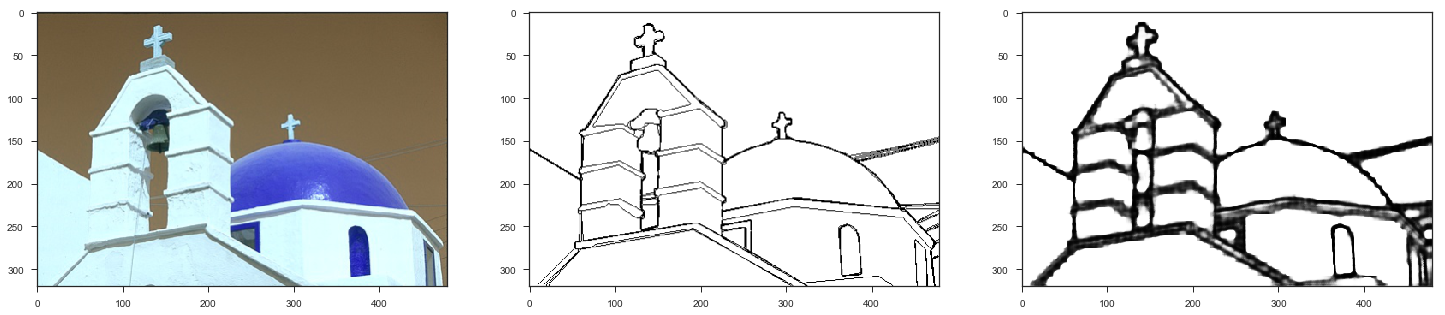

In [10]:
y_pred = model_unet_fuse.predict(X_train[18].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred_HED.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.9] = 1
# y_pred[y_pred <= 0.1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[18], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[18].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()

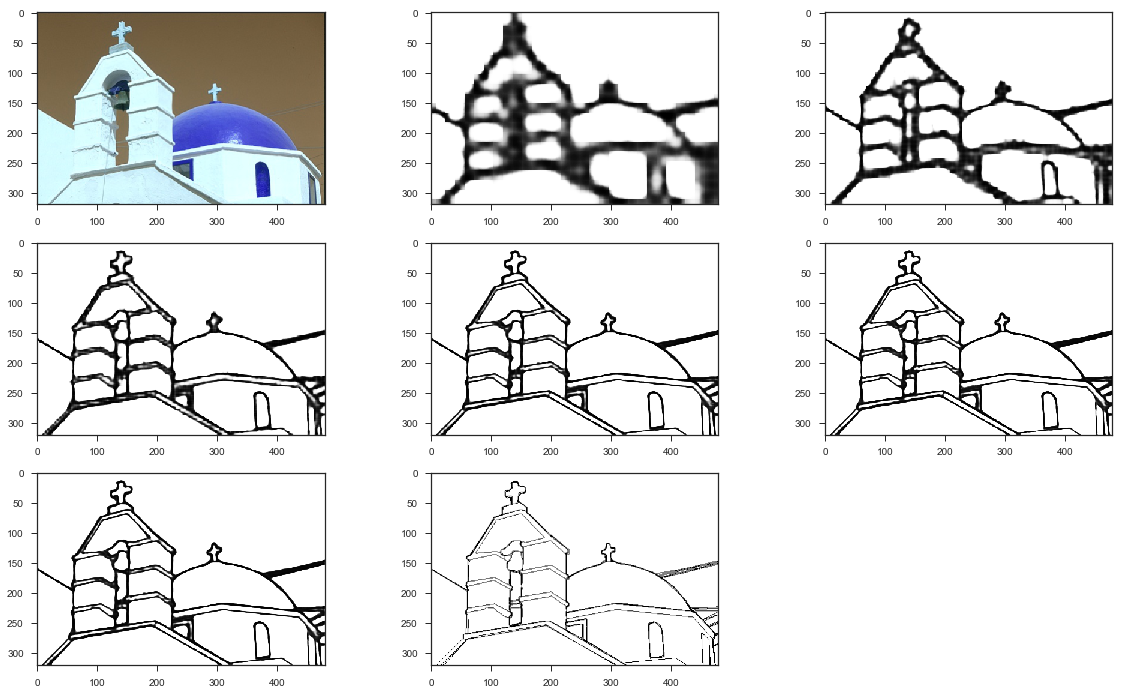

In [15]:
y_pred = model_unet_fuse.predict(X_train[18].reshape((-1,320,480,3)))
plt.figure(figsize=(20, 12))
for i in range(0, 8):
    plt.subplot(3, 3, i+1)
    if i == 0:
        plt.imshow(X_train[18], cmap='binary')
    elif i == 7:
        plt.imshow(y_train[18].reshape((320, 480)), cmap='binary')
    else:
        plt.imshow(y_pred[i-1].reshape((320, 480)), cmap='binary')
plt.show()

In [18]:
model_unet_fuse.save_weights(WEIGHT_PATH + 'UNET_fuse_weight.h5')
model_unet_fuse.save(MODEL_PATH + 'UNET_fuse_model.h5')
model_json = model_unet_fuse.to_json()
with open(MODEL_PATH + 'UNET_fuse_model.json', "w") as json_file:
    json_file.write(model_json)

In [20]:
model_unet_load = u_net_fuse(input_shape=(320, 480, 3))
model_unet_load.load_weights('/media/tulan/Linux/Pycharm/Image_Edge/weight/UNET_fuse_weight.h5')

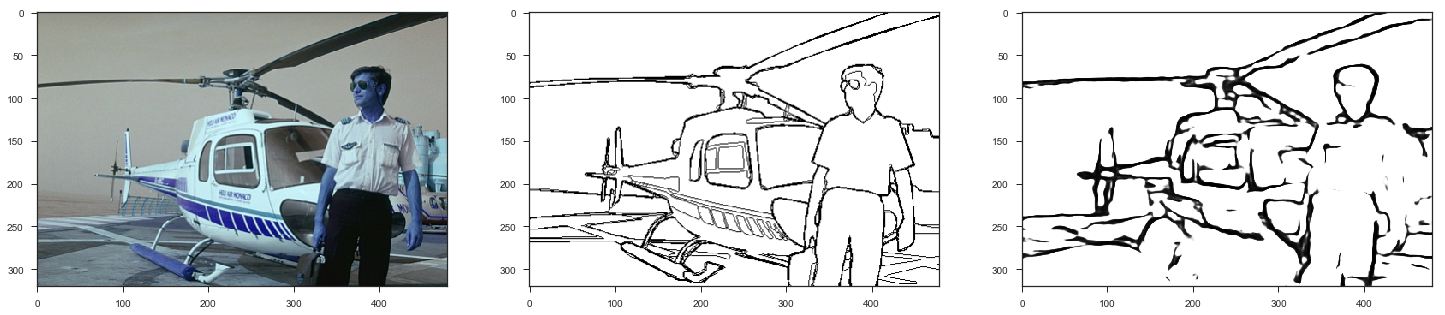

In [26]:
y_pred = model_unet_load.predict(X_test[44].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
# np.savetxt(RESULT_PATH + '/sample_pred.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.5] = 1
# y_pred[y_pred < 0.5] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_test[44], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_test[44].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()